# Statistical Deviation Event Detector

For the eye activation detection task, there is a clear trend in the data - measuring the data with open eyes outputs a clearly different DC Voltage than measuring the data with eyes closed. This can be observed in the sample data below.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch

## Experimenting with scale & deviation for Point Process Generation

In [2]:
#Digilent WaveForms Oscilloscope Acquisition
#Device Name: Discovery2
#Serial Number: SN:210321B5D9FA
#Date Time: 2025-02-13 12:33:16.223
#Sample rate: 136.533Hz
#Samples: 5800
#Trigger: Source: Channel 1 Type: Edge Condition: Rising Level: 0 V Hyst.: Auto HoldOff: 0 s
#Channel 1: Range: 200 mV/div Offset: -2 V Sample Mode: Average
#Channel 2: Range: 500 mV/div Offset: 0 V Sample Mode: Average
#Power Supplies: ON
#Positive Supply: ON
#Voltage: 5 V
#Negative Supply: ON
#Voltage: -5 V

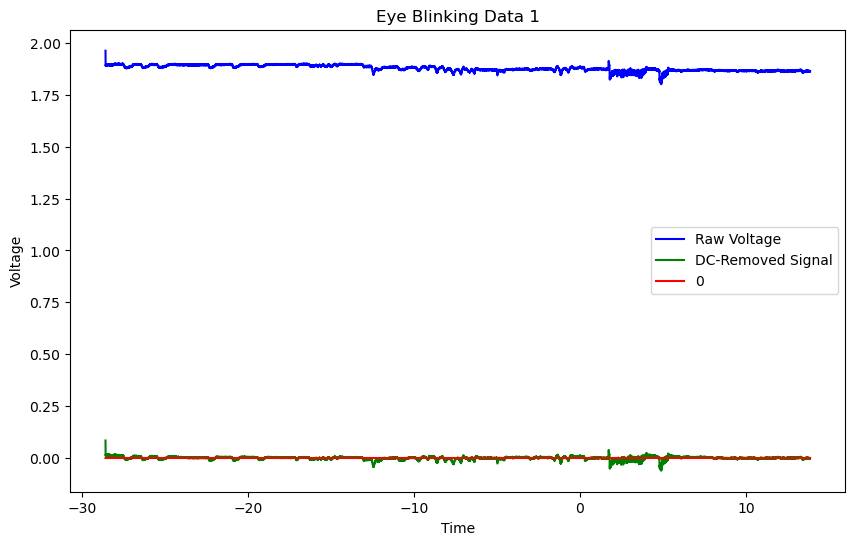

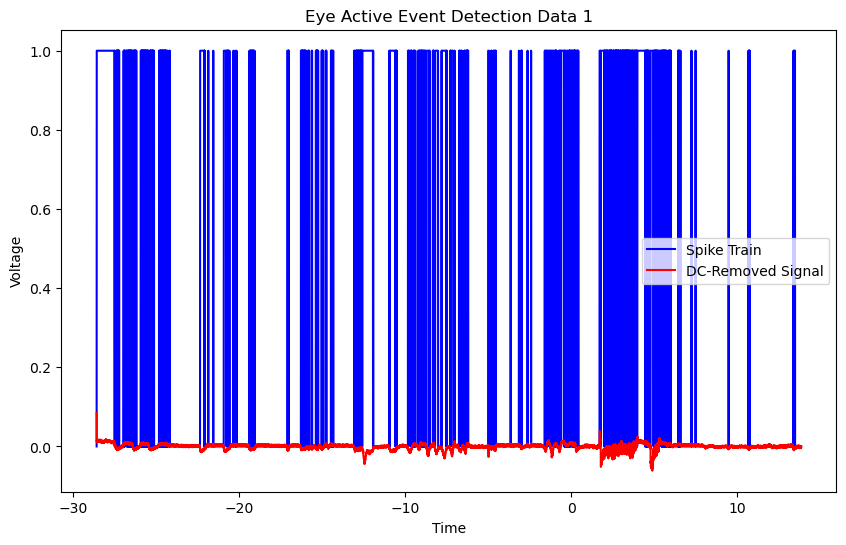

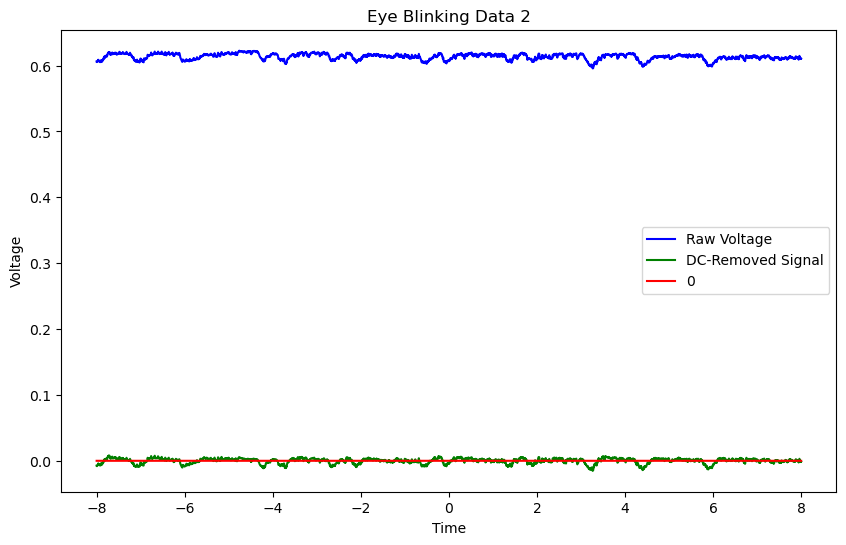

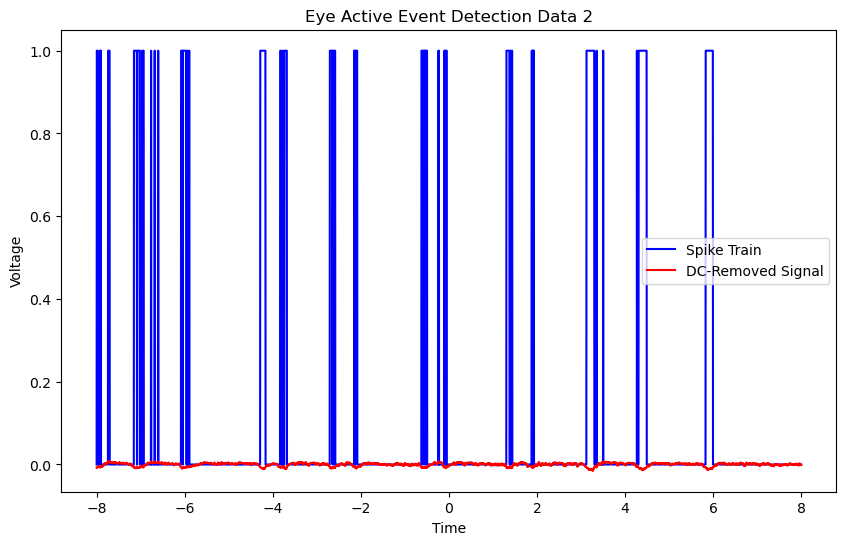

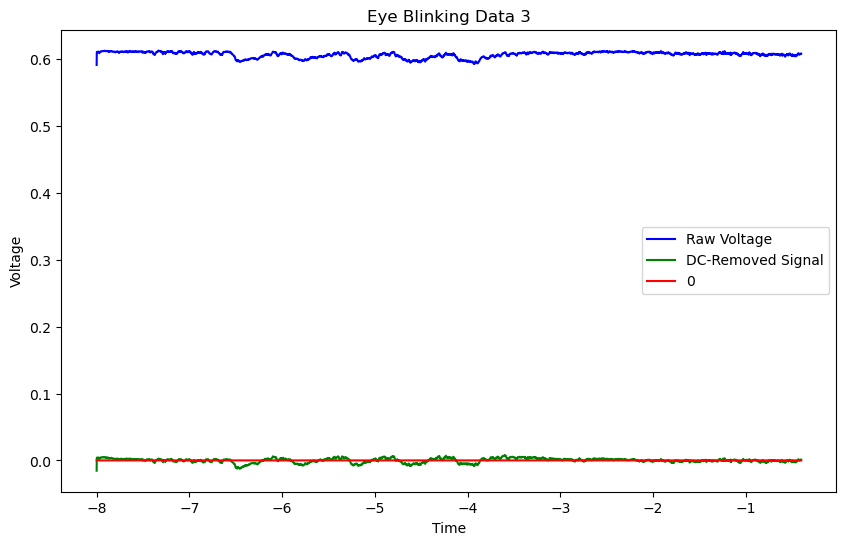

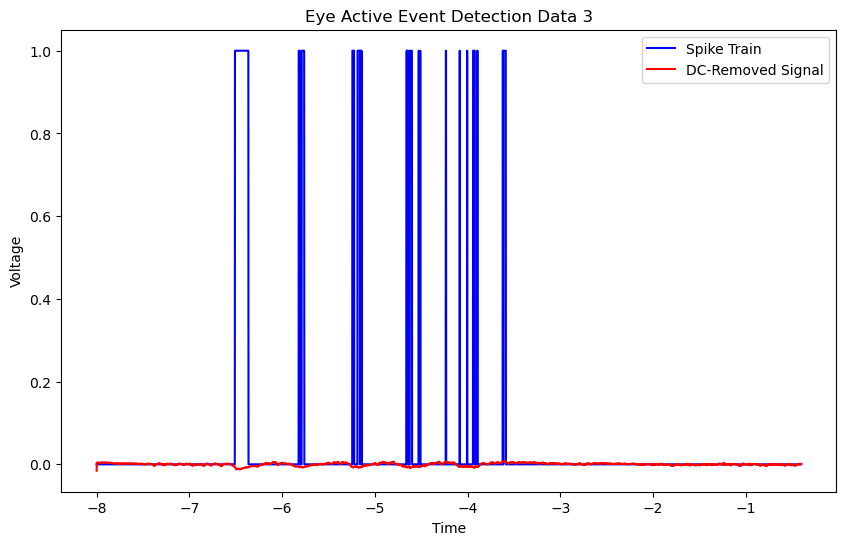

Average Standard Deviation: 0.0015041653676661434


In [ ]:
M = 10
filter = - np.ones(M) / np.sqrt(M)
applied_filter = 0
scale = 1.2
deviation = 0.005477277382981891 # Empirically determined standard deviation threshold
threshold = scale*deviation # Empirically determined standard deviation threshold

avg_std = 0

#for i in range(10):
for i in [1, 2, 3]:
    # Load the data
    data = pd.read_csv(f'eye_blinking{i}.csv', delimiter=',')
    # Drop Channel2
    data = data.drop(columns=['Channel2'])
    
    voltage = data['Channel1']
    time = data['Time']

    N = len(voltage)

    # DC tracking
    start = np.mean(voltage)
    dc_track = np.zeros(N)
    dc_track[0] = start

    spike_train = np.zeros(N)

    alpha = 0.005
    for j in range(1, N):
        dc_track[j] = dc_track[j - 1] * (1 - alpha) + voltage[j] * alpha

        if np.abs(voltage[j] - dc_track[j]) > threshold:
            spike_train[j] = 1  

    # Compute the DC-removed signal
    dc_removed_voltage = voltage - dc_track

    std_removed_voltage = np.std(dc_removed_voltage)
    avg_std += std_removed_voltage/10

    # Plot the transformed signals
    plt.figure(figsize=(10, 6))
    plt.plot(time, voltage, 'b', label='Raw Voltage')
    plt.plot(time, dc_removed_voltage, 'g', label='DC-Removed Signal')
    plt.plot(time, np.zeros_like(voltage), 'r', label='0')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'Eye Blinking Data {i}')
    plt.show()

    # Plot the event detection
    plt.figure(figsize=(10, 6))
    plt.plot(time, spike_train, 'b', label='Spike Train')
    plt.plot(time, dc_removed_voltage, 'r', label='DC-Removed Signal')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'Eye Active Event Detection Data {i}')
    plt.show()

print(f'Average Standard Deviation: {avg_std}')



# idk yet

Processing experiment 1 ...


C:\Users\valle\AppData\Local\Temp\ipykernel_17024\2702017008.py:57: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(f"wink{i}_received_data.txt", skiprows=4, delimiter=', ')


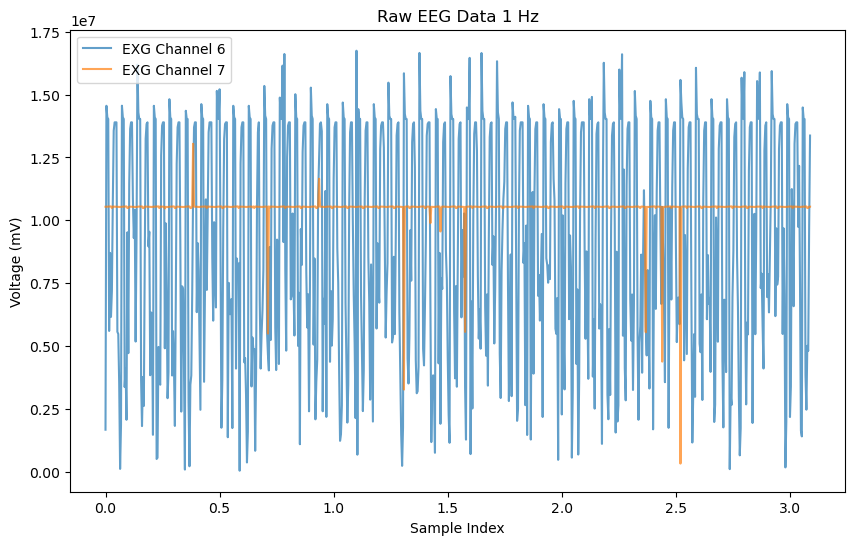

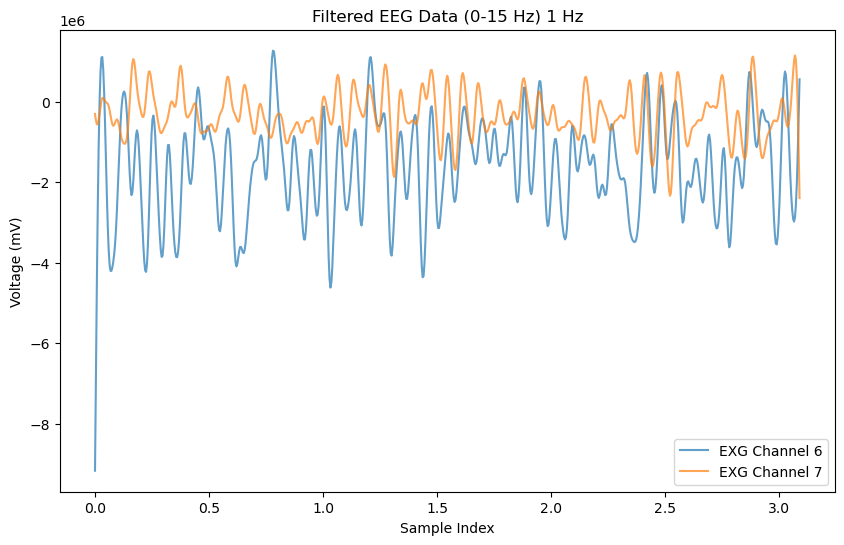

c:\Users\valle\radioconda\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 1000 is greater than input length  = 773, using nperseg = 773
  warnings.warn('nperseg = {0:d} is greater than input length '


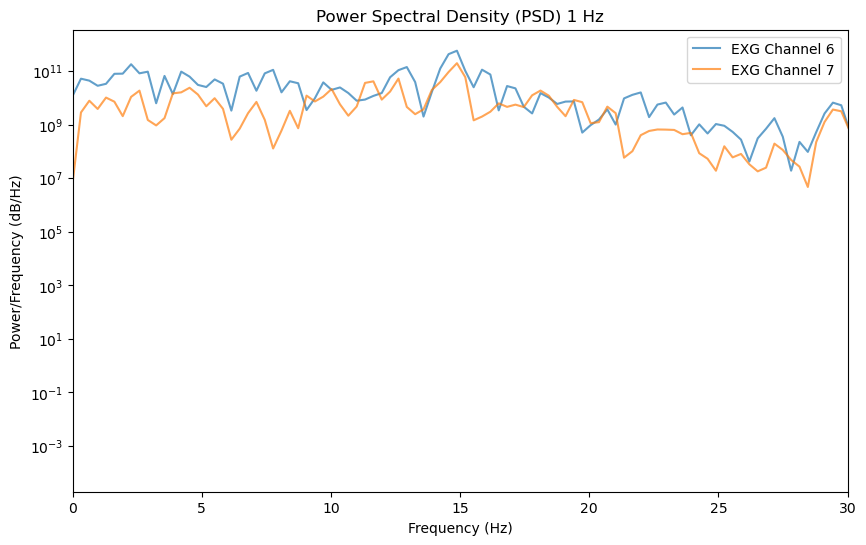

Processing experiment 2 ...


C:\Users\valle\AppData\Local\Temp\ipykernel_17024\2702017008.py:57: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(f"wink{i}_received_data.txt", skiprows=4, delimiter=', ')


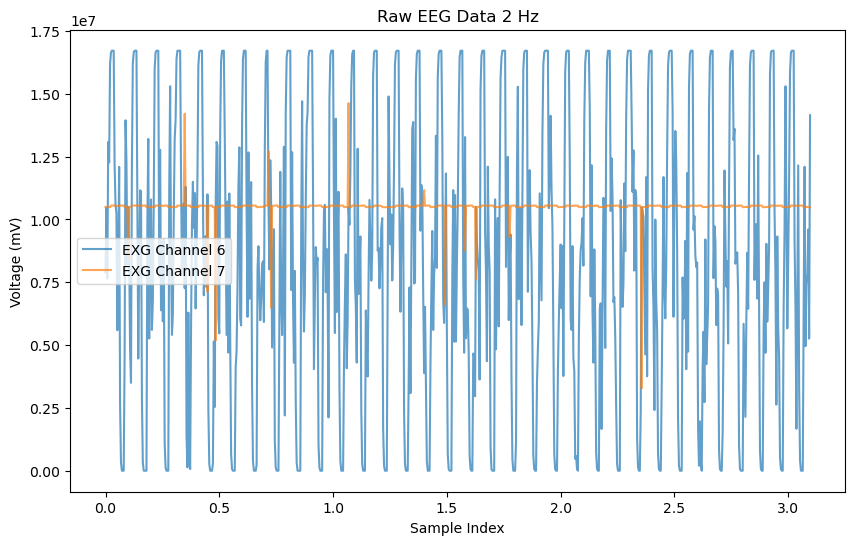

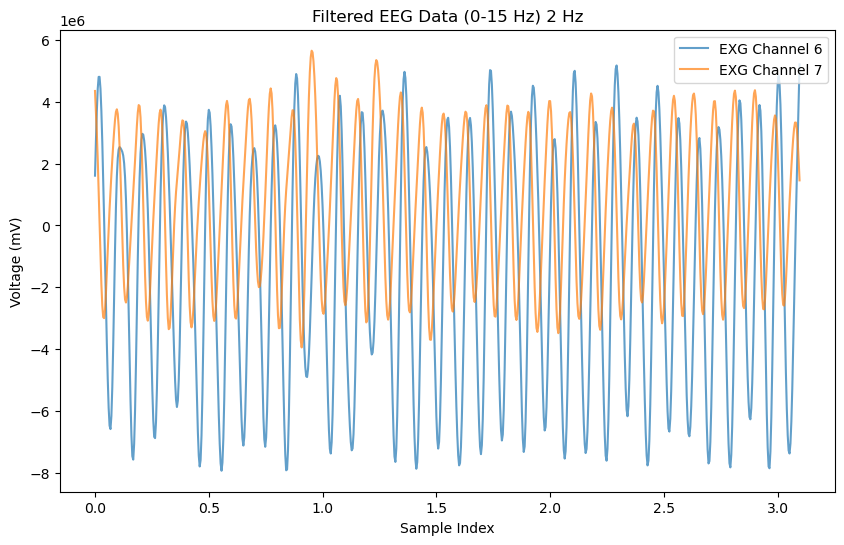

c:\Users\valle\radioconda\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 1000 is greater than input length  = 775, using nperseg = 775
  warnings.warn('nperseg = {0:d} is greater than input length '


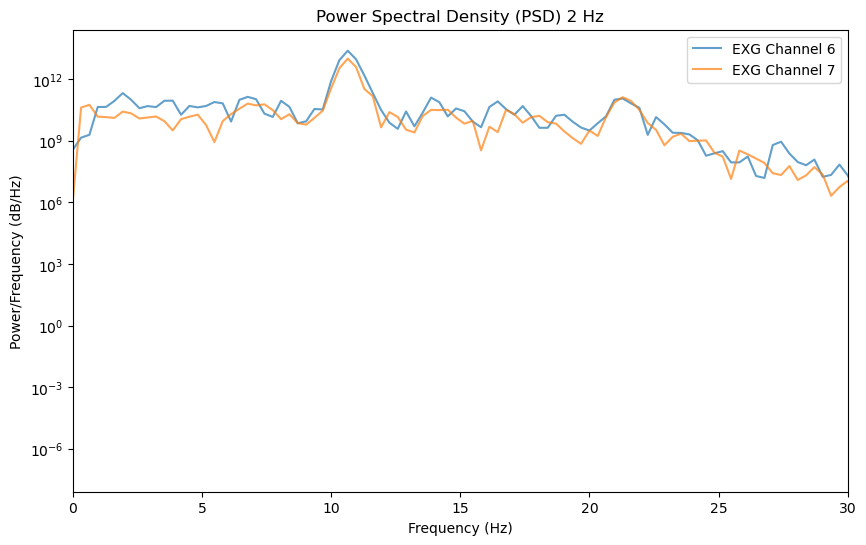

Processing experiment 3 ...


C:\Users\valle\AppData\Local\Temp\ipykernel_17024\2702017008.py:57: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(f"wink{i}_received_data.txt", skiprows=4, delimiter=', ')


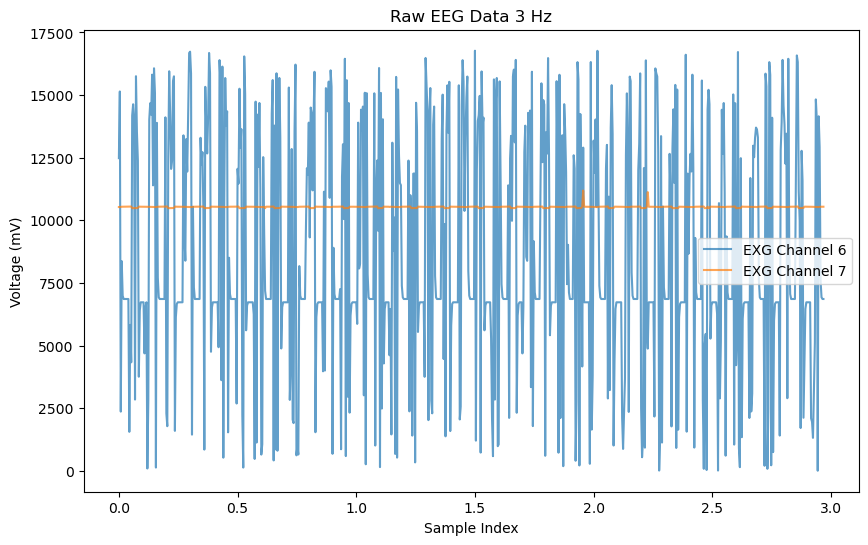

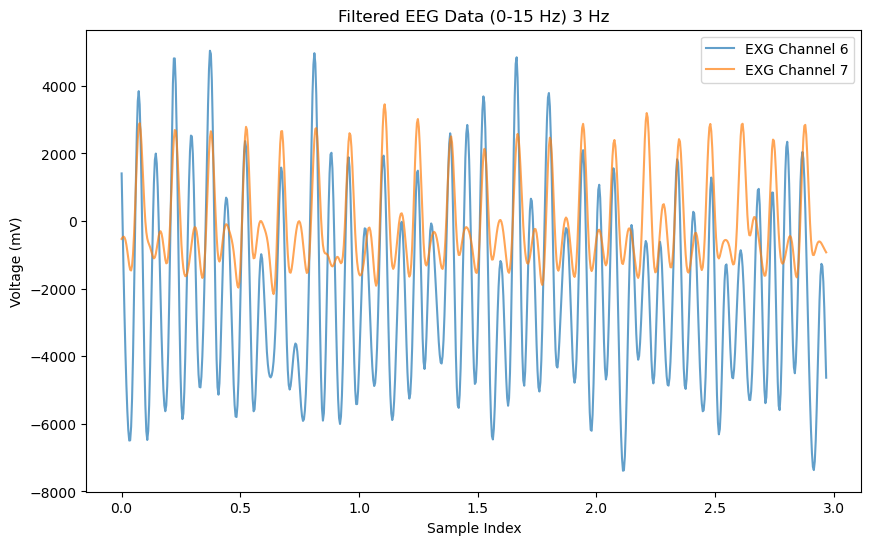

c:\Users\valle\radioconda\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 1000 is greater than input length  = 743, using nperseg = 743
  warnings.warn('nperseg = {0:d} is greater than input length '


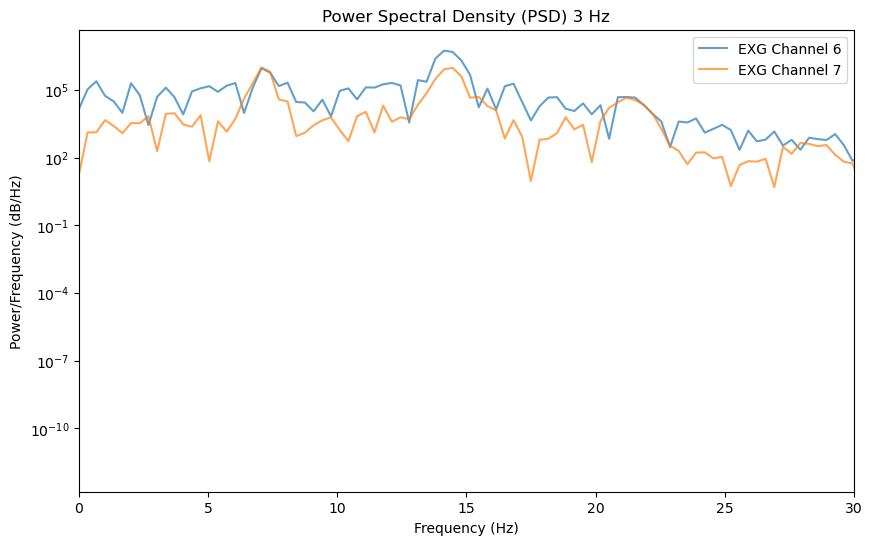

In [4]:
# Sampling frequency
fs = 250  # Hz

# EEG Essential Channels
essential_channels = [
    'EXG Channel 6', 'EXG Channel 7'
]

# EEG Channels to Keep
keep_channels = [
    'EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2', 'EXG Channel 3',
    'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6', 'EXG Channel 7'
]

# Channels to Drop
drop_channels = [
    'Accel Channel 0', 'Accel Channel 1', 'Accel Channel 2', 'Not Used',
    'Digital Channel 0 (D11)', 'Digital Channel 1 (D12)', 'Digital Channel 2 (D13)',
    'Digital Channel 3 (D17)', 'Not Used', 'Digital Channel 4 (D18)', 
    'Analog Channel 0', 'Analog Channel 1', 'Analog Channel 2',
    'Timestamp', 'Marker Channel', 'Timestamp (Formatted)'
]

# Define a Bandpass Butterworth Filter (1-40 Hz)
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Define a Lowpass Butterworth Filter (40 Hz)
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

# Apply a Bandpass Filter to the EEG Data
def apply_bandpass_filter(data, fs, lowcut=1, highcut=40):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, data, axis=0)

# Apply a Lowpass Filter to the EEG Data
def apply_lowpass_filter(data, fs, cutoff=40):
    b, a = butter_lowpass(cutoff, fs)
    return filtfilt(b, a, data, axis=0)

# Loop over conditions (7 Hz, 11 Hz, 15 Hz stimuli)
#for i in [7, 11, 15]:
for i in [1, 2, 3]:
    #print(f"Processing {i} Hz experiment...")
    print(f"Processing experiment {i} ...")
    
    # Load data
    #df = pd.read_csv(f"received_data_{i}Hz.txt", skiprows=4, delimiter=', ')
    df = pd.read_csv(f"wink{i}_received_data.txt", skiprows=4, delimiter=', ')
    
    # Drop unwanted channels and handle NaNs
    df = df.drop(columns=drop_channels, errors='ignore').dropna().reset_index(drop=True)

    # Plot Raw EEG Signals
    plt.figure(figsize=(10, 6))
    for channel in essential_channels:
        plt.plot(df['Sample Index']/(1.0*fs), df[channel], label=channel, alpha=0.7)
    plt.legend()
    plt.xlabel('Sample Index')
    plt.ylabel('Voltage (mV)')
    plt.title(f'Raw EEG Data {i} Hz')
    plt.show()

    # Apply Common Average Referencing (CAR)
    common_avg_reference = df[keep_channels].mean(axis=1)
    df[keep_channels] = df[keep_channels].sub(common_avg_reference, axis=0)

    # Apply Bandpass Filter (1-40 Hz)
    #df[keep_channels] = apply_bandpass_filter(df[keep_channels].values, fs)
    df[keep_channels] = apply_lowpass_filter(df[keep_channels].values, fs, cutoff=20)

    # Plot Filtered EEG Signals
    plt.figure(figsize=(10, 6))
    for channel in essential_channels:
        plt.plot(df['Sample Index']/(1.0*fs), df[channel], label=channel, alpha=0.7)
    plt.legend()
    plt.xlabel('Sample Index')
    plt.ylabel('Voltage (mV)')
    plt.title(f'Filtered EEG Data (0-15 Hz) {i} Hz')
    plt.show()

    # Compute PSD using Welch's Method
    plt.figure(figsize=(10, 6))
    for channel in essential_channels:
        f, Pxx = welch(df[channel], fs=fs, nperseg= 4 * fs, noverlap=2 * fs, window='hann')
        plt.semilogy(f, Pxx, label=channel, alpha=0.7)  # Log scale for better visibility

    plt.legend()
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.title(f'Power Spectral Density (PSD) {i} Hz')
    plt.xlim(0, 30)  # Focus on relevant EEG frequencies
    plt.show()


Processing Experiment 1...


C:\Users\valle\AppData\Local\Temp\ipykernel_17024\1166491673.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(f"wink{i}_received_data.txt", skiprows=4, delimiter=', ')


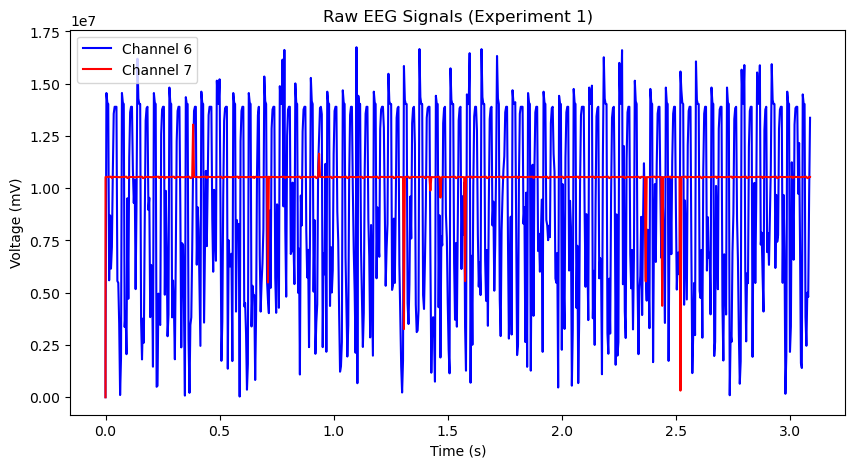

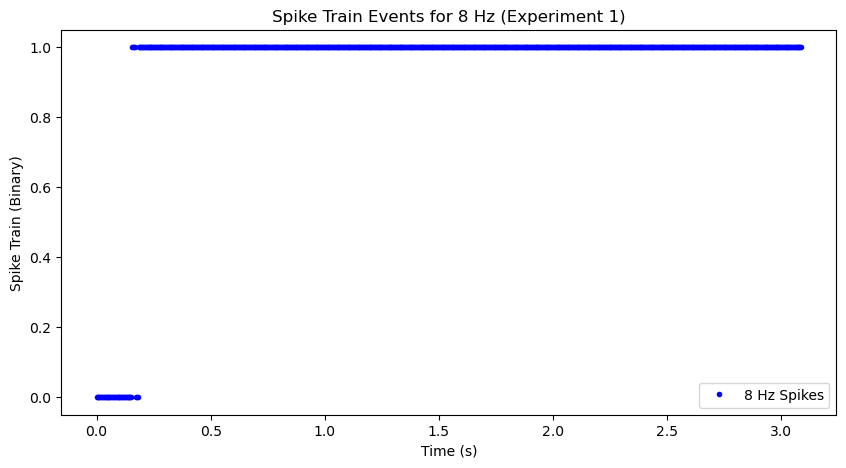

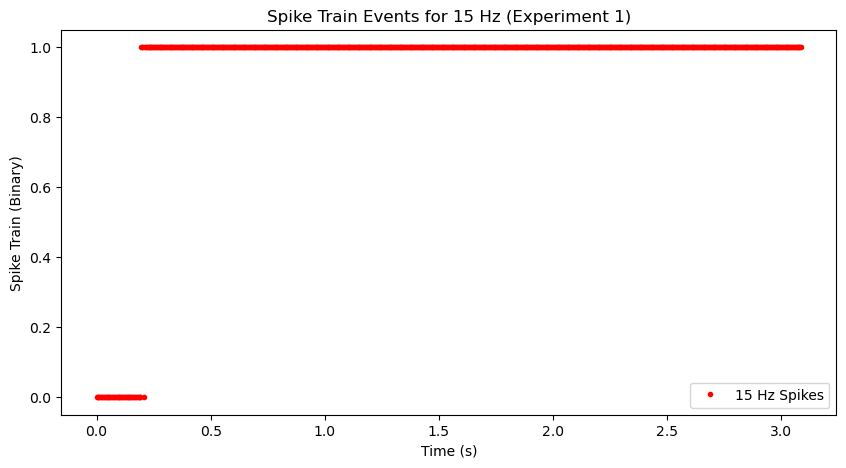

Processing Experiment 2...


C:\Users\valle\AppData\Local\Temp\ipykernel_17024\1166491673.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(f"wink{i}_received_data.txt", skiprows=4, delimiter=', ')


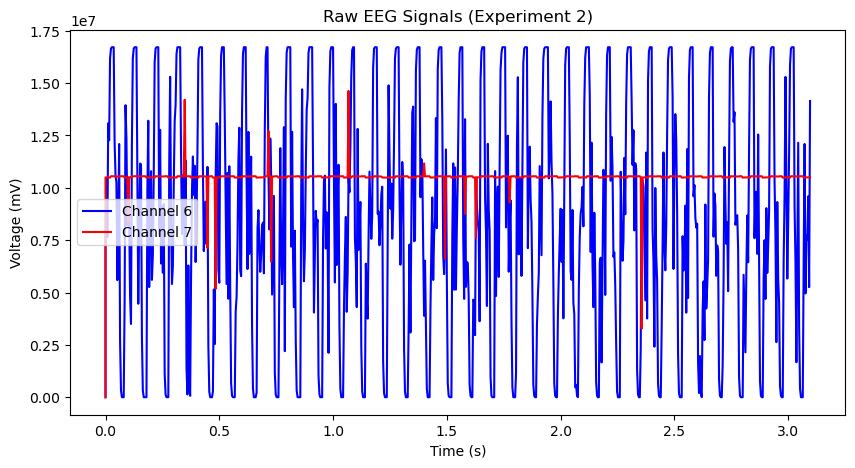

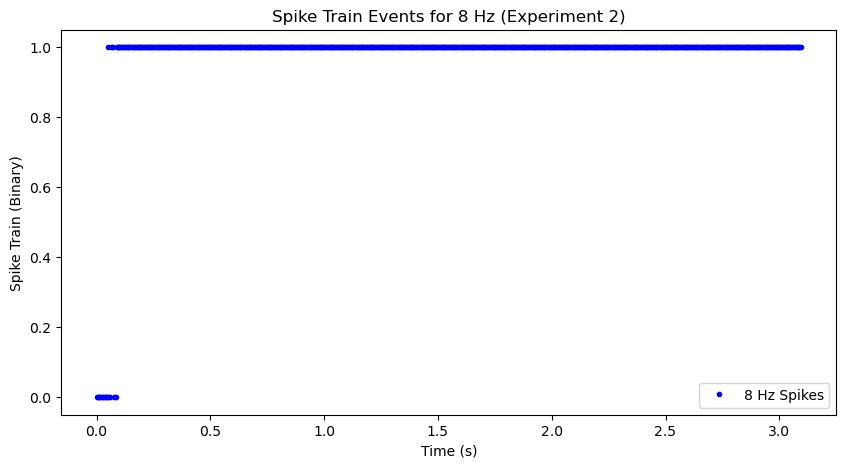

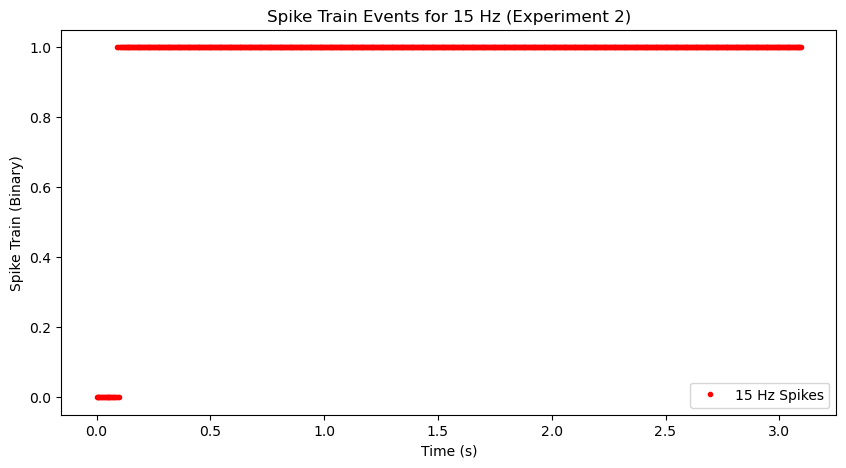

Processing Experiment 3...


C:\Users\valle\AppData\Local\Temp\ipykernel_17024\1166491673.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(f"wink{i}_received_data.txt", skiprows=4, delimiter=', ')


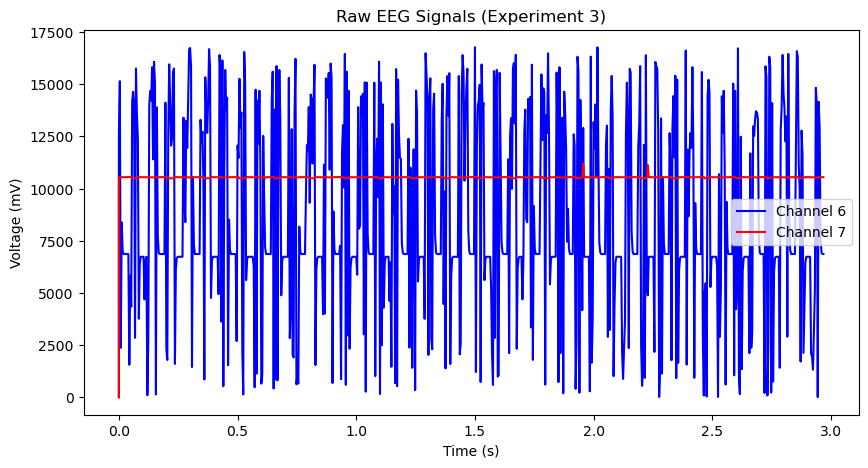

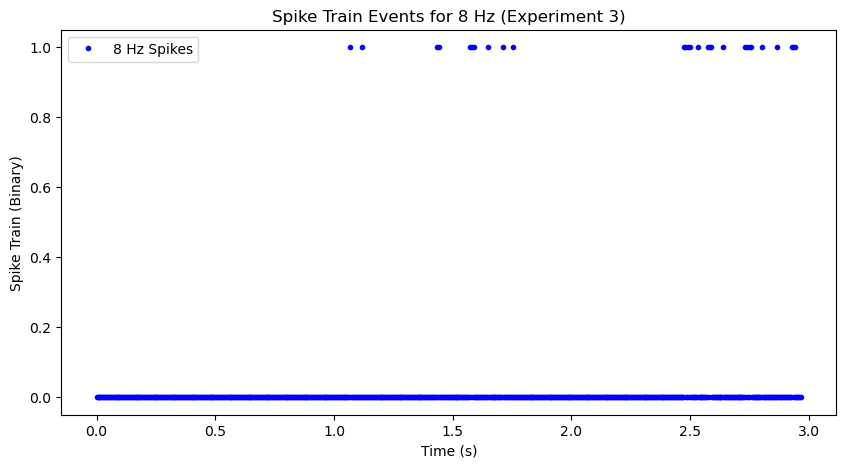

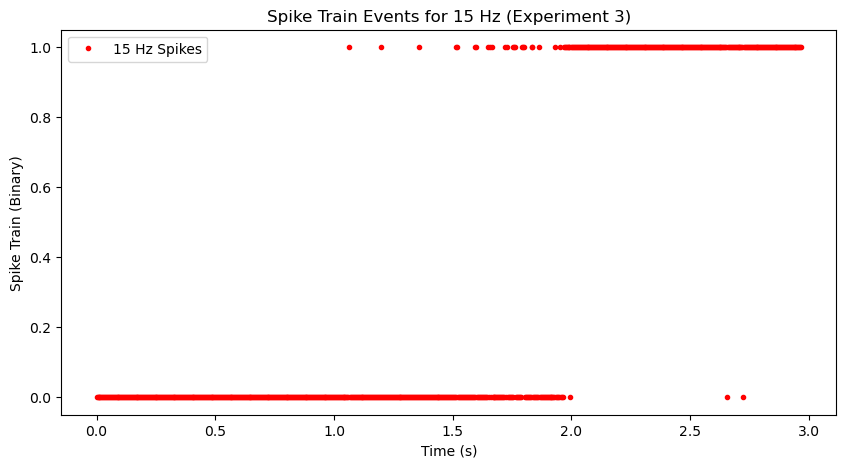

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert, welch

# Sampling frequency
fs = 250  # Hz
window_size = 1.0  # seconds (real-time update window)
samples_per_window = int(fs * window_size)


# Channels to Drop
drop_channels = [
    'Accel Channel 0', 'Accel Channel 1', 'Accel Channel 2', 'Not Used',
    'Digital Channel 0 (D11)', 'Digital Channel 1 (D12)', 'Digital Channel 2 (D13)',
    'Digital Channel 3 (D17)', 'Not Used', 'Digital Channel 4 (D18)', 
    'Analog Channel 0', 'Analog Channel 1', 'Analog Channel 2',
    'Timestamp', 'Marker Channel', 'Timestamp (Formatted)'
]

# Essential EEG Channels
essential_channels = ['EXG Channel 6', 'EXG Channel 7']

# Define Bandpass Filter for Specific Frequencies
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, fs, lowcut, highcut):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, data, axis=0)

# Function to Detect 8 Hz & 15 Hz Power and Generate Spike Trains
def detect_activity(signal, fs, threshold_factor=2.0):
    spike_8Hz = 0
    spike_15Hz = 0

    # Bandpass filter for 8 Hz & 15 Hz
    signal_8Hz = apply_bandpass_filter(signal, fs, 7, 9)
    signal_15Hz = apply_bandpass_filter(signal, fs, 14, 16)

    # Compute power via Hilbert Transform
    power_8Hz =  np.abs(hilbert(signal_8Hz)) ** 2
    power_15Hz = np.abs(hilbert(signal_15Hz)) ** 2

    # Compute mean power per window
    mean_power_8Hz = np.mean(power_8Hz)
    mean_power_15Hz = np.mean(power_15Hz)

    # Adaptive thresholding
    threshold_8Hz = threshold_factor * np.std(signal)
    threshold_15Hz = threshold_factor * np.std(signal)

    # Detect events and set spike train values
    if mean_power_8Hz > threshold_8Hz:
        spike_8Hz = 1  # Mark event

    if mean_power_15Hz > threshold_15Hz:
        spike_15Hz = 1  # Mark event

    return spike_8Hz, spike_15Hz

# Loop Over Experiments (Wink Conditions)

for i in [1, 2, 3]:
    print(f"Processing Experiment {i}...")

    # Load Data
    df = pd.read_csv(f"wink{i}_received_data.txt", skiprows=4, delimiter=', ')
    
    # Drop unnecessary channels
    df = df.drop(columns=drop_channels, errors='ignore')
    
    # Initialize Spike Trains
    detected_spike_trains_8Hz = np.zeros((len(df.columns)-1, len(df)))
    detected_spike_trains_15Hz = np.zeros((len(df.columns)-1, len(df)))

    # Convert Sample Index to Time (seconds)
    t = df['Sample Index'] / fs
    t_ext = np.pad(t, (samples_per_window-1, 0), mode='constant')
    channel6 = np.pad(df['EXG Channel 6'], (samples_per_window-1, 0), mode='constant')
    channel7 = np.pad(df['EXG Channel 7'], (samples_per_window-1, 0), mode='constant')
    # Combine Channels for Ease
    channels = np.zeros((2, len(df) + samples_per_window-1))
    channels[0] = channel6
    channels[1] = channel7
    # Apply Common Average Referencing (CAR)
    common_avg_reference = channels.mean(axis=0)
    channels = channels - common_avg_reference
    # Initialize Spike Trains
    spike_train_8Hz = np.zeros(len(t))
    spike_train_15Hz = np.zeros(len(t))

    # Real-time Detection & Spike Train Generation
    for start_idx in range(len(t)):
        for channel in [0, 1]:
            signal_buffer = channels[channel, start_idx:start_idx + samples_per_window]
            spikes_8Hz, spikes_15Hz = detect_activity(signal_buffer, fs, threshold_factor=100)

            spike_train_8Hz[start_idx] = spikes_8Hz
            spike_train_15Hz[start_idx] = spikes_15Hz

    # Plot Signals
    plt.figure(figsize=(10, 5))
    plt.plot(t_ext, channel6, 'b', label='Channel 6')
    plt.plot(t_ext, channel7, 'r', label='Channel 7')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title(f'Raw EEG Signals (Experiment {i})')
    plt.legend()
    plt.show()

    # Plot Spike Trains
    plt.figure(figsize=(10, 5))
    plt.plot(t, spike_train_8Hz, 'bo', markersize=3, label='8 Hz Spikes')
    plt.xlabel('Time (s)')
    plt.ylabel('Spike Train (Binary)')
    plt.title(f'Spike Train Events for 8 Hz (Experiment {i})')
    plt.legend()
    plt.show()

    # Plot Spike Trains
    plt.figure(figsize=(10, 5))
    plt.plot(t, spike_train_15Hz, 'ro', markersize=3, label='15 Hz Spikes')  # Shifted for visibility
    plt.xlabel('Time (s)')
    plt.ylabel('Spike Train (Binary)')
    plt.title(f'Spike Train Events for 15 Hz (Experiment {i})')
    plt.legend()
    plt.show()

Processing Experiment 1...


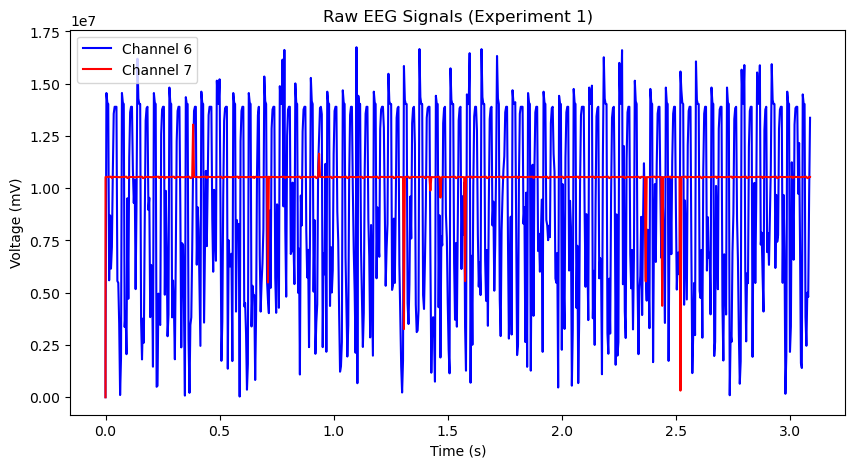

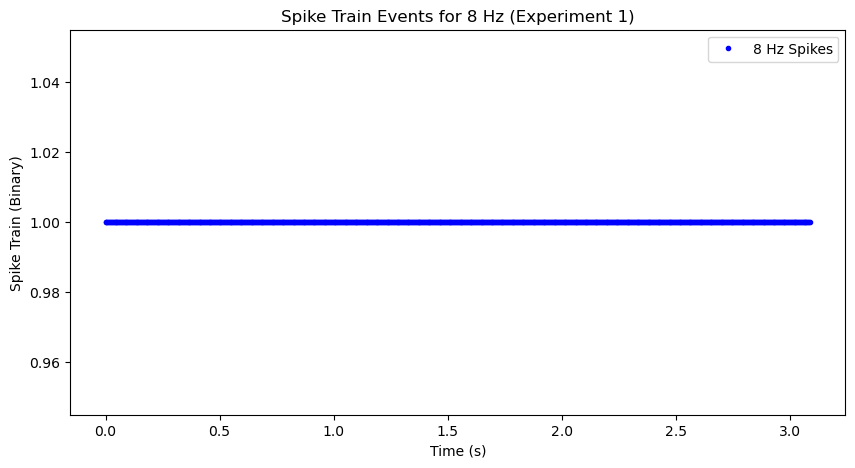

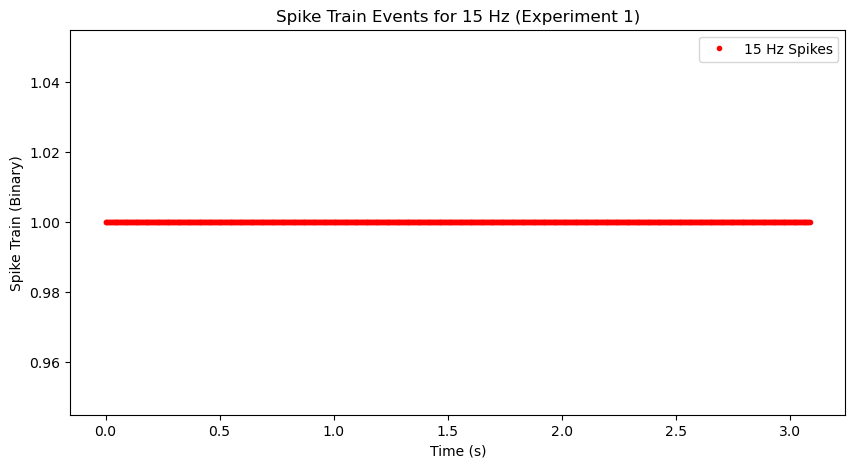

Processing Experiment 2...


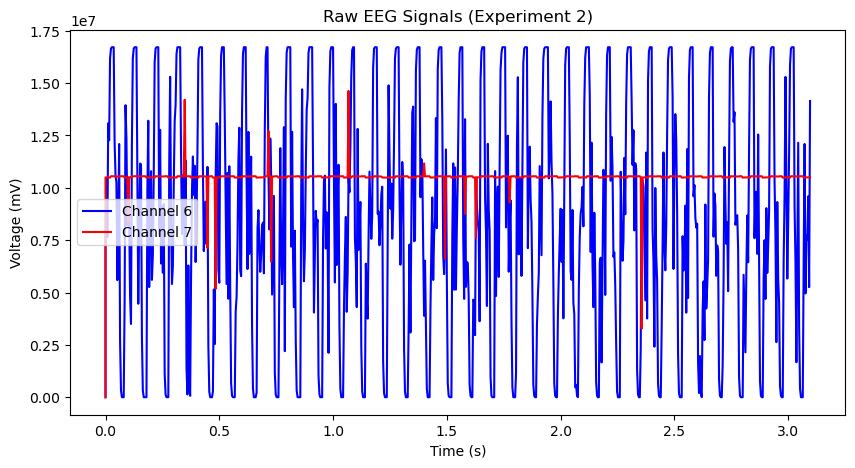

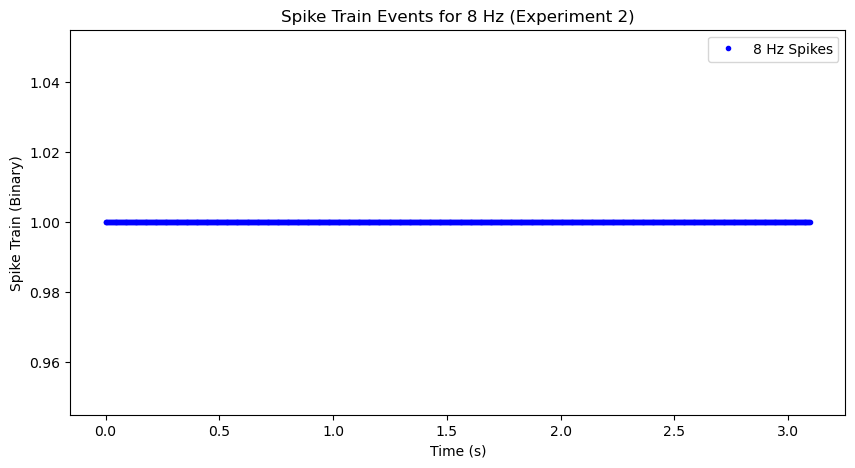

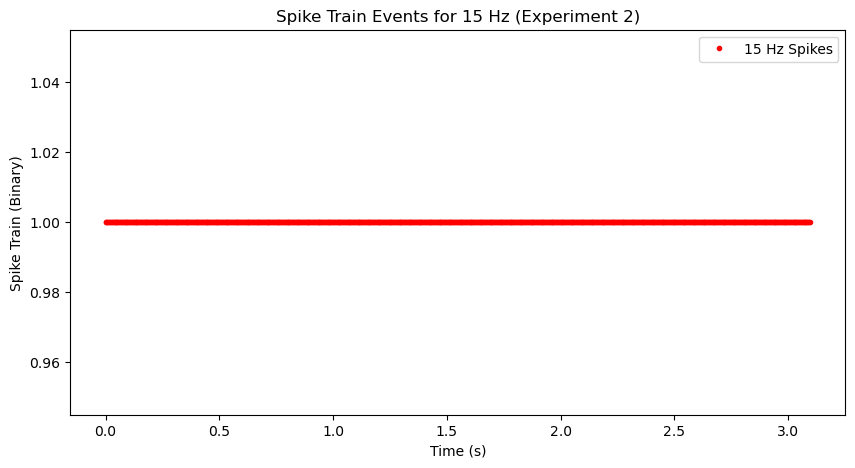

Processing Experiment 3...


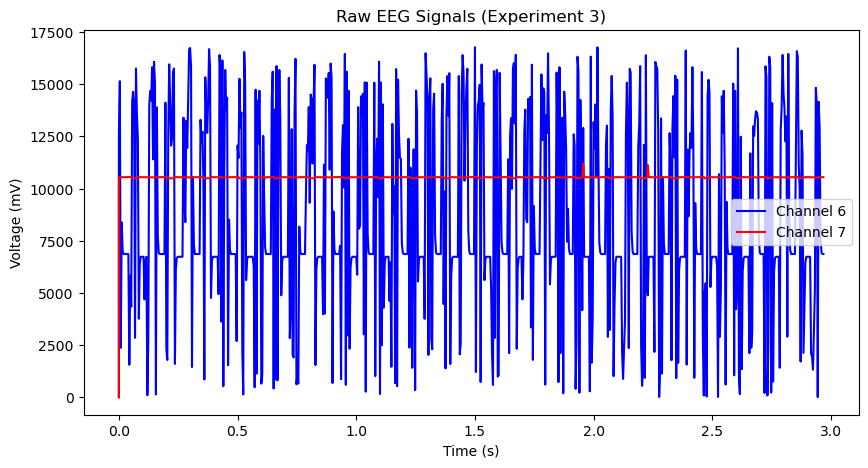

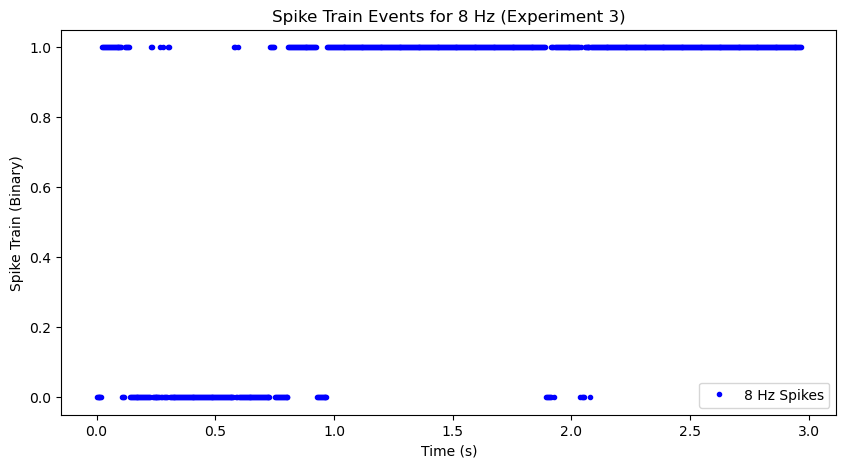

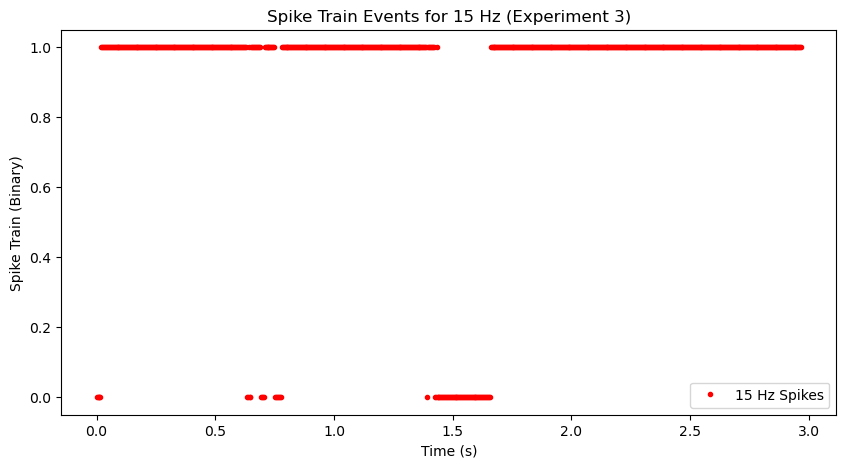

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sampling frequency
fs = 250  # Hz
window_size = 1.0  # seconds (real-time update window)
samples_per_window = int(fs * window_size)

# Channels to Drop
drop_channels = [
    'Accel Channel 0', 'Accel Channel 1', 'Accel Channel 2', 'Not Used',
    'Digital Channel 0 (D11)', 'Digital Channel 1 (D12)', 'Digital Channel 2 (D13)',
    'Digital Channel 3 (D17)', 'Not Used', 'Digital Channel 4 (D18)', 
    'Analog Channel 0', 'Analog Channel 1', 'Analog Channel 2',
    'Timestamp', 'Marker Channel', 'Timestamp (Formatted)'
]

# Essential EEG Channels
essential_channels = ['EXG Channel 6', 'EXG Channel 7']

# **Goertzel Algorithm for Frequency Detection**
def goertzel(signal, fs, target_freq):
    """Computes the power of a target frequency in the signal using Goertzel's algorithm."""
    N = len(signal)  # Window size
    k = int(0.5 + (N * target_freq) / fs)
    omega = (2.0 * np.pi * k) / N
    coeff = 2.0 * np.cos(omega)

    s_prev = 0.0
    s_prev2 = 0.0

    for sample in signal:
        s = sample + coeff * s_prev - s_prev2
        s_prev2 = s_prev
        s_prev = s

    power = s_prev2**2 + s_prev**2 - coeff * s_prev * s_prev2
    return power

# **Function to Detect 8 Hz & 15 Hz Events**
def detect_activity(signal, fs, threshold_factor=2.0):
    spike_8Hz = 0
    spike_15Hz = 0

    # Compute Goertzel power for 8 Hz and 15 Hz
    power_8Hz = goertzel(signal, fs, 8)
    power_15Hz = goertzel(signal, fs, 15)

    # Adaptive thresholding
    threshold_8Hz = threshold_factor * np.std(signal)
    threshold_15Hz = threshold_factor * np.std(signal)

    # Detect events and set spike train values
    if power_8Hz > threshold_8Hz:
        spike_8Hz = 1  # Mark event

    if power_15Hz > threshold_15Hz:
        spike_15Hz = 1  # Mark event

    return spike_8Hz, spike_15Hz

# **Loop Over Experiments (Wink Conditions)**
for i in [1, 2, 3]:
    print(f"Processing Experiment {i}...")

    # Load Data
    df = pd.read_csv(f"wink{i}_received_data.txt", skiprows=4, delimiter=', ', engine='python')
    
    # Drop unnecessary channels
    df = df.drop(columns=drop_channels, errors='ignore')
    
    # Initialize Spike Trains
    spike_train_8Hz = np.zeros(len(df))
    spike_train_15Hz = np.zeros(len(df))

    # Convert Sample Index to Time (seconds)
    t = df['Sample Index'] / fs
    t_ext = np.pad(t, (samples_per_window-1, 0), mode='constant')
    
    # Pad EEG Channels for Processing
    channel6 = np.pad(df['EXG Channel 6'], (samples_per_window-1, 0), mode='constant')
    channel7 = np.pad(df['EXG Channel 7'], (samples_per_window-1, 0), mode='constant')

    # Combine Channels for Ease
    channels = np.vstack((channel6, channel7))

    # Apply Common Average Referencing (CAR)
    common_avg_reference = channels.mean(axis=0)
    channels = channels - common_avg_reference

    # **Real-time Detection & Spike Train Generation**
    for start_idx in range(len(t)):
        for channel in [0, 1]:
            signal_buffer = channels[channel, start_idx:start_idx + samples_per_window]
            spikes_8Hz, spikes_15Hz = detect_activity(signal_buffer, fs, threshold_factor=100000)

            spike_train_8Hz[start_idx] = spikes_8Hz
            spike_train_15Hz[start_idx] = spikes_15Hz

    # **Plot Raw EEG Signals**
    plt.figure(figsize=(10, 5))
    plt.plot(t_ext, channel6, 'b', label='Channel 6')
    plt.plot(t_ext, channel7, 'r', label='Channel 7')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title(f'Raw EEG Signals (Experiment {i})')
    plt.legend()
    plt.show()

    # **Plot Spike Trains for 8 Hz**
    plt.figure(figsize=(10, 5))
    plt.plot(t, spike_train_8Hz, 'bo', markersize=3, label='8 Hz Spikes')
    plt.xlabel('Time (s)')
    plt.ylabel('Spike Train (Binary)')
    plt.title(f'Spike Train Events for 8 Hz (Experiment {i})')
    plt.legend()
    plt.show()

    # **Plot Spike Trains for 15 Hz**
    plt.figure(figsize=(10, 5))
    plt.plot(t, spike_train_15Hz, 'ro', markersize=3, label='15 Hz Spikes')  # Shifted for visibility
    plt.xlabel('Time (s)')
    plt.ylabel('Spike Train (Binary)')
    plt.title(f'Spike Train Events for 15 Hz (Experiment {i})')
    plt.legend()
    plt.show()


In [7]:
df = pd.read_csv('wink1_received_data.txt', skiprows=4, delimiter=', ')
print(len(df))
channel = 'EXG Channel 6'
print(df[channel].shape)

773
(773,)


C:\Users\valle\AppData\Local\Temp\ipykernel_17024\2363901382.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('wink1_received_data.txt', skiprows=4, delimiter=', ')
